# Links
* [Predicting customer churn (what this notebook is based on)](http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html?utm_campaign=Submission&utm_medium=Community&utm_source=GrowthHackers.com)
* [Confusion Matrix Code Example](http://notmatthancock.github.io/2015/10/28/confusion-matrix.html)
* [Simple Guide To Confusion Matrix Terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
* [Wikipedia - Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* [scikit-learn Documentation - Confusion Matrix](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
* [Learn scikit-learn](http://www.dataschool.io/machine-learning-with-scikit-learn/)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

churn_df = pd.read_csv('\\\\svrau085ssm01.oceania.corp.anz.com\\torriea$\\My Documents\\bokeh_data\\churn.csv')
col_names = churn_df.columns.tolist()

print "Column names:"
print col_names

to_show = col_names[:6] + col_names[-6:]

print "\nSample data:"
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [2]:
# isolate target data
# by converting True. -> 1, and False. -> 0
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [3]:
# we don't need these columns
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
churn_feat_space = churn_df.drop(to_drop, axis = 1)

In [4]:
# 'yes'/'no' has to be converted to boolean values
# numpy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan", "VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [5]:
# pull out features for future use
features = churn_feat_space.columns
X = churn_feat_space.as_matrix().astype(np.float)

In [6]:
# this is important (why??)
# Many predictors care about the relative size of different features even though those scales might be arbitrary. 
# For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude 
# larger than their win percentage. But this doesn't mean that the latter is 100 times less significant. StandardScaler 
# fixes this by normalizing each feature to a range of around 1.0 to -1.0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [7]:
# cross validation
from sklearn.cross_validation import KFold

def run_cv(X, y, clf_class, **kwargs):
    # construct a kfolds object
    kf = KFold(len(y), n_folds = 5, shuffle = True)
    y_pred = y.copy()
    
    # iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # initialise a classifier with key word arguments
        clf = clf_class(**kwargs)
        #clf.fit(X_train, y_train)
        y_pred[test_index] = clf.fit(X_train, y_train).predict(X_test)
        
    return y_pred

In [8]:
# compare three fairly unique algorithms support vector machines, random forest, and k-nearest-neighbors. 
# Nothing fancy here, just passing each to cross validation and determining how often the classifier 
# predicted the correct class
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

print "Support vector machines:"
print "%.3f" % accuracy_score(y, run_cv(X, y, SVC))
print "\nRandom forest:"
print "%.3f" % accuracy_score(y, run_cv(X, y, RF))
print "\nK-nearest-neighbours:"
print "%.3f" % accuracy_score(y, run_cv(X, y, KNN))

Support vector machines:
0.918

Random forest:
0.944

K-nearest-neighbours:
0.893


In [9]:
# confusion matrix
# The x-axis indicates the true class of each observation (if a customer churned or not) 
# while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).
from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ("Support Vector Machine", confusion_matrix(y, run_cv(X, y, SVC))),
    ("Random Forest", confusion_matrix(y, run_cv(X, y, RF))),
    ("K-Nearest-Neighbour", confusion_matrix(y, run_cv(X, y, KNN))),
]

In [10]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    tick_marks = np.arange(len(class_names))
    outcome_annotation = dict(fc='w',boxstyle='round, pad=1')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.045)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    # outcomes
    tn = cm[0, 0]; fp = cm[0, 1]; fn = cm[1, 0]; tp = cm[1, 1]; nobs = cm.sum()
    
    # true negative annotation
    plt.text(0, 0, 'TN: %d' % tn, va='center', ha='center', bbox=outcome_annotation)
    
    # false negative annotation
    plt.text(0, 1, 'FN: %d' % fn, va='center', ha='center', bbox=outcome_annotation)
    
    # false positive annotation
    plt.text(1, 0, 'FP: %d' % fp, va='center', ha='center', bbox=outcome_annotation)
    
    # true positive annotation
    plt.text(1, 1, 'TP: %d' % tp, va='center', ha='center', bbox=outcome_annotation)


    
def draw_confusion_matrices(confusion_matrices, class_names):
    fig = plt.figure(num = 1, figsize=(14, 8))

    for index, cm in enumerate(confusion_matrices):
        fig.add_subplot(130 + index + 1)
        plot_confusion_matrix(cm[1], cm[0])
        
    plt.show()

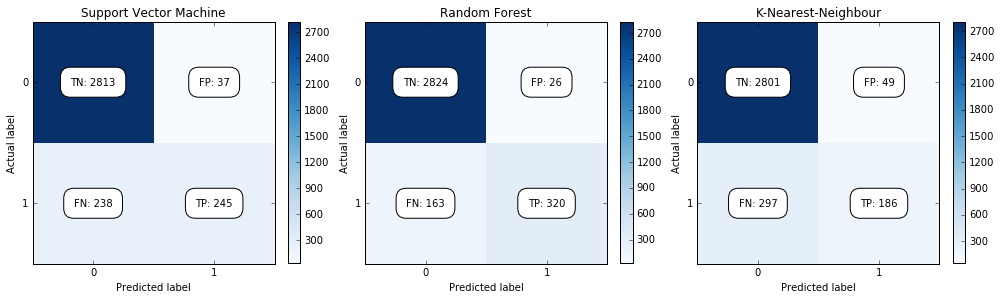


Support Vector Machine

accuracy			91.75%		Overall, how often is the classifier correct?

error_rate			8.25%		Overall, how often is it wrong?

recall				50.72%		When it's actually yes, how often does it predict yes?

false_positive_rate		1.30%		When it's actually no, how often does it predict yes? (Type I error)

false_negative_rate		49.28%		When it's actually yes, how often does it predict no? (Type II error)

specificity			98.70%		When it's actually no, how often does it predict no?

precision			86.88%		When it predicts yes, how often is it correct?

prevelance			14.49%		How often does the yes condition actually occur in our sample?

positive_likelihood_ratio	39.07		

negative_likelihood_ratio	0.50		

diagnostic_odds_ratio		78.26		Higher diagnostic odds ratios are indicative of better test performance



Random Forest

accuracy			94.33%		Overall, how often is the classifier correct?

error_rate			5.67%		Overall, how often is it wrong?

recall				66.25%		When it's actually yes, how o

In [11]:
draw_confusion_matrices(confusion_matrices, class_names)

for index, item in enumerate(confusion_matrices):
    name = item[0]
    cm = item[1]
    
    # outcomes
    tn = cm[0, 0]; fp = cm[0, 1]; fn = cm[1, 0]; tp = cm[1, 1]; nobs = cm.sum()

    # performance metrics
    actual_positive = tp + fn + 0.
    actual_negative = fp + tn + 0.
    predicted_positive = tp + fp + 0.
    accuracy = (tp + tn + 0.) / nobs
    error_rate = 1. - accuracy
    recall = tp / actual_positive
    false_positive_rate = fp / actual_negative
    false_negative_rate = fn / actual_positive
    specificity = 1. - false_positive_rate
    precision = tp / predicted_positive
    prevelance = actual_positive / nobs
    positive_likelihood_ratio = recall / false_positive_rate
    negative_likelihood_ratio = false_negative_rate / specificity
    diagnostic_odds_ratio = positive_likelihood_ratio / negative_likelihood_ratio

    print "\n" + name
    print "=" * len(name)
    print "\naccuracy\t\t\t%.2f%%" % (accuracy * 100) + "\t\tOverall, how often is the classifier correct?"
    print "\nerror_rate\t\t\t%.2f%%" % (error_rate * 100) + "\t\tOverall, how often is it wrong?"
    print "\nrecall\t\t\t\t%.2f%%" % (recall * 100) + "\t\tWhen it's actually yes, how often does it predict yes?"
    print "\nfalse_positive_rate\t\t%.2f%%" % (false_positive_rate * 100) + "\t\tWhen it's actually no, how often does it predict yes? (Type I error)"
    print "\nfalse_negative_rate\t\t%.2f%%" % (false_negative_rate * 100) + "\t\tWhen it's actually yes, how often does it predict no? (Type II error)"
    print "\nspecificity\t\t\t%.2f%%" % (specificity * 100) + "\t\tWhen it's actually no, how often does it predict no?"
    print "\nprecision\t\t\t%.2f%%" % (precision * 100) + "\t\tWhen it predicts yes, how often is it correct?"
    print "\nprevelance\t\t\t%.2f%%" % (prevelance * 100) + "\t\tHow often does the yes condition actually occur in our sample?"
    print "\npositive_likelihood_ratio\t%.2f" % positive_likelihood_ratio + "\t\t"
    print "\nnegative_likelihood_ratio\t%.2f" % negative_likelihood_ratio + "\t\t"
    print "\ndiagnostic_odds_ratio\t\t%.2f" % (diagnostic_odds_ratio) + "\t\tHigher diagnostic odds ratios are indicative of better test performance"
    print "\n"
